In [48]:
class display(object):
    """
    Produce el código HTML para visualizar múltiples objetos
    """
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)


# K Means

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline


blobs = pd.read_csv('kmeans_blobs.csv')
colnames = list(blobs.columns[1:-1])
blobs.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


In [3]:
def init_centroids(k, dset):
    '''
    entrega una cantidad de centroides
    (eligiendo puntos aleatorios para comenzar)
    k: numero de centroides
    dset: pandas datafrmae
    '''
    centroids = dset.sample(k)
    return centroids

np.random.seed(42)
k=3
df = blobs[['x','y']]
centroids = init_centroids(k, df)
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


In [9]:
def rsserr(a,b):
    '''
    a,b son arreglos numpy
    calcula la suma de la diferencia de sus cuadrados
    '''
    return np.sum( (a-b)**2 )

In [30]:
def indexofminimum(a):
    '''
    -> (index, value)
    Retorna el index de un arreglo de numpy a,
    donde se encuentra el minimo, y el valor de ese minimo
    '''
    minimo =  np.amin(a)
    return list(np.where( a == minimo)[0])[0], minimo

indexofminimum([34,412,643,123,13])

(4, 13)

In [34]:
dato_testing = df.iloc[1,:]

for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], dato_testing)
    print('Error para centroide {0}: {1:.2f}'.format(i, err))

Error para centroide 0: 546.44
Error para centroide 1: 459.93
Error para centroide 2: 665.43


In [17]:
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


### consiguiendo centroides

In [21]:
dset = df

k = centroids.shape[0]
n = dset.shape[0]
assignation = []
assign_errors = []

for obs in range(n):
    # estima el error de cada centroide
    all_errors = np.array([])
    for centroid in range(k):
        err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
        all_errors = np.append(all_errors, err) #arreglo numpy con error por centroid

print(all_errors)

[463.585778 382.715892 564.799621]


## Asigna los centroides


In [31]:
def centroid_assignation(dset, centroids):
    '''
    Dado un dataframe y un set de centroides, se asigna
    a cada punto de dset a un centroide
    - dset - pandas dataframe with observations
    - centroids - pandas dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # estima el error de cada centroide
        error_array = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            error_array = np.append(error_array, err) #arreglo numpy con error por centroid

        # nr_cntr : nearest centroid
        nr_cntr, nr_cntr_error = indexofminimum( error_array )

        # agrega el valor a la lista correspondiente
        assignation.append(nr_cntr)
        assign_errors.append(nr_cntr_error)

    return assignation, assign_errors

In [49]:
# asignamos los centroides
df['centroid'], df['error'] = centroid_assignation(df, centroids)
df.head()

,x,y,centroid,error
0,24.412,32.932,2,94.740741
1,35.190,12.189,1,46.033021
2,26.288,41.718,2,21.972002
3,0.376,15.506,0,150.360777
4,26.116,3.963,1,62.886921


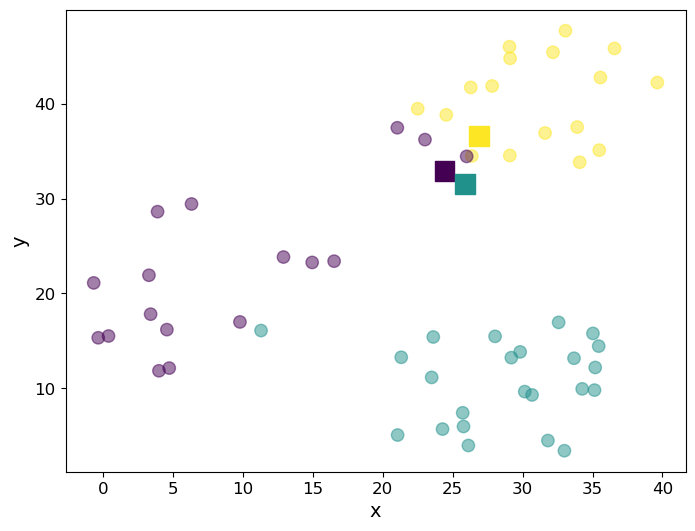

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2]
            )
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [39]:
print("El error total {0:.2f}".format(df['error'].sum()))

El error total 20606.95


## Actualiza los centroides


In [51]:
# promedio de las posiciones de los datos en funcion de su centroide
# esto es distintos de nuestros centroides

centroid_means = df.groupby('centroid').agg('mean')
centroids

display('centroid_means', 'centroids')

centroid_means
                  x          y      error
centroid                                 
0          6.322867  19.559800  82.185178
1         29.330864  10.432409  41.211471
2         29.304957  39.050783  49.891045

centroids
           x          y
0   9.889444  23.242611
1  28.435750  11.546250
2  30.759333  40.311167

In [40]:
centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,x,y
0,9.889444,23.242611
1,28.435750,11.546250
2,30.759333,40.311167


luego calculamos si es menor a una tolerancia y entregaremos en caso de coseguirlo
